# 2. Digits Classification with K Nearest Neighbors (40 points)

## Imports

In [83]:
import numpy as np
import matplotlib.pyplot as plt

## Appendix: Python Tips

### Loading and Visualizing MNIST-5-6-Subset Data

In [84]:
# Load the data from MNIST-5-6-Subset.txt
# Change the path as needed
data_file_path = "data/MNIST-5-6-Subset.txt"
data_matrix = np.loadtxt(data_file_path).reshape(1877, 784)
# Load the labels from MNIST-5-6-Labels.txt
# Change the path as needed
labels_file_path = "data/MNIST-5-6-Subset-Labels.txt"
labels = np.loadtxt(labels_file_path)

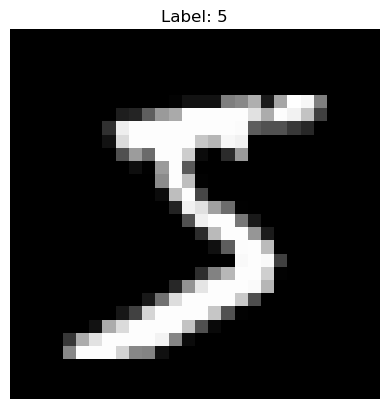

In [85]:
# Assuming you want to visualize the first image
# Change the index as needed
image_index = 0
image_data = data_matrix[image_index]
selected_label = int(labels[image_index])
# Visualize the image using Matplotlib
# We transpose the image to make the number look upright.
plt.imshow(image_data.reshape(28,28).transpose(1,0), cmap='gray')
plt.title(f"Label: {selected_label}")
plt.axis('off') # Turn off axis
plt.show()

### Setting up a figure with axis labels, legend and title

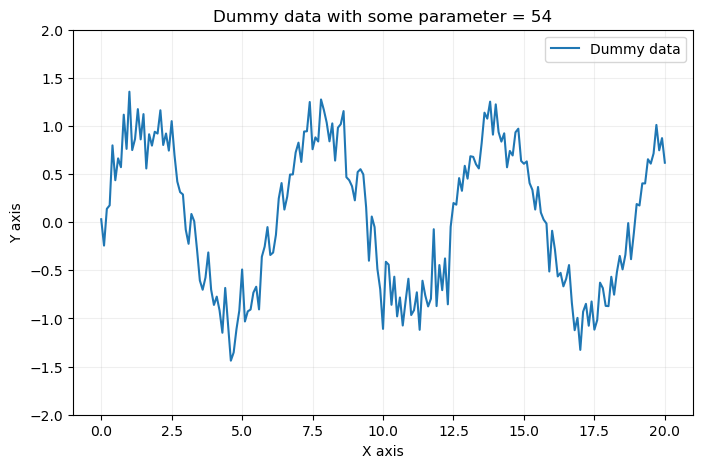

In [86]:
# Dummy data, x and y
x = np.arange(0, 20.1, 0.1)
y = np.sin(x) + np.random.normal(0, 0.2, len(x))
some_parameter = 54
# Initialise figure (fig) and axis (ax)
fig, ax = plt.subplots(figsize=(8,5))
# Plot in axis, add label to data
ax.plot(x, y, label='Dummy data') # (*)
# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title(f'Dummy data with some parameter = {some_parameter}')
# Add grid
ax.grid(alpha=0.2)
# Set axes limits
ax.set_ylim(-2,2)
# Add legend (remember to label the data as shown above (*))
ax.legend()
# Show plot
plt.show()
# Save plot to some local path
fig.savefig('output/validation_err.png')

### Using vector operations with Numpy

In [87]:
# Say we have a data matrix with dimension (50, 10)
data_matrix = np.random.rand(50, 10)
print('data_matrix shape:', data_matrix.shape)
# .. and we want to subtract from all of its columns a vector of dimension (10)
some_vector = np.random.rand(10)
print('some_vector shape:', some_vector.shape)
# Instead of looping through the data matrix and subtracting like so,
result_loop = np.zeros_like(data_matrix)
for i,column in enumerate(data_matrix):
    result_loop[i] = column - some_vector
print('result_loop shape:', result_loop.shape)
# We can use vector operations to greatly improve the speed,
# at which we achieve the same result.
# The essential action involves expanding the dimensions of "some_vector",
# aligning it with the dimensions of
# the "data_matrix." np.newaxis␣ accomplishes this by encapsulating
# the original data with ":", while simultaneously creating a new dimension.
some_vector_new = some_vector[np.newaxis, :]
print('some_vector shape after expansion:', some_vector_new.shape)
# Now we can subtract some_vector simply like this
result_vector = data_matrix - some_vector_new
print('result_vector shape:', result_vector.shape)
# Assert that the two results are equal
print('result_loop == result_vector:', np.all(result_loop == result_vector))
# We can easily check how large of a speedup we achieve by using the time package
from time import time
loop_time = []
vector_time = []
for _ in range(250):
    # For loop
    t = time()
    for i,column in enumerate(data_matrix):
        result_loop[i] = column - some_vector
    loop_time.append(t - time())
    # Vector operation
    t = time()
    result_vector = data_matrix - some_vector[np.newaxis, :]
    vector_time.append(t - time())

print(f'Speed up: {(np.mean(loop_time) / np.mean(vector_time)):1.3f}')

data_matrix shape: (50, 10)
some_vector shape: (10,)
result_loop shape: (50, 10)
some_vector shape after expansion: (1, 10)
result_vector shape: (50, 10)
result_loop == result_vector: True
Speed up: 244.853


### Other useful Numpy functions: cumsum, sort and argsort

In [88]:
# Creating an example array
data = np.array([5, 2, 8, 1, 6])
# 1)
# Calculating cumulative sum using cumsum
cumulative_sum = np.cumsum(data)
print("Original data:", data)
print("Cumulative sum:", cumulative_sum)
# Documentation for np.cumsum: https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html
# 2)
# Sorting the array using sort
sorted_data = np.sort(data)
print("\nOriginal data:", data)
print("Sorted data:", sorted_data)
# Documentation for np.sort: https://numpy.org/doc/stable/reference/generated/numpy.sort.html
# 3)
# Getting indices that would sort the array using argsort
sorted_indices = np.argsort(data)
print("\nOriginal data:", data)
print("Sorted indices:", sorted_indices)
# Documentation for np.argsort: https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
# 4)
# Accessing elements in sorted order using sorted indices
sorted_data_using_indices = data[sorted_indices]
print("\nOriginal data:", data)
print("Sorted data using indices:", sorted_data_using_indices)

Original data: [5 2 8 1 6]
Cumulative sum: [ 5  7 15 16 22]

Original data: [5 2 8 1 6]
Sorted data: [1 2 5 6 8]

Original data: [5 2 8 1 6]
Sorted indices: [3 1 0 4 2]

Original data: [5 2 8 1 6]
Sorted data using indices: [1 2 5 6 8]


## Task 1

### Load data and define training and test sets

In [89]:
# Load data
data_file_path = "MNIST-5-6-Subset/MNIST-5-6-Subset.txt"
labels_file_path = "MNIST-5-6-Subset/MNIST-5-6-Subset-Labels.txt"
data_matrix = np.loadtxt(data_file_path).reshape(1877, 784)
labels = np.loadtxt(labels_file_path)

# Number of training points
m = 50

# Define training points and labels
training_points = data_matrix[:, :m]
training_labels = labels[:m]
test_point = data_matrix[:, m + 1]
test_label = labels[m + 1]

### Function knn

In [90]:
# See Algorithm 1 on page 6 in [YS]
def knn(training_points, training_labels, test_point, test_label): #TODO: only this function, not all of your code, the completecode should be included in the .zip file.)
    # 1. Convert labels from {5, 6} to {-1, 1}
    training_labels = np.where(training_labels == 5, -1, 1)
    test_label = -1 if test_label == 5 else 1
    
    # 2. Calculate pairwise distances (d_i = d(x_i, x)) between test point and training points
    distances = np.linalg.norm(training_points - test_point[:, np.newaxis], axis=0)
    
    # 3. Sort distances (d_i's) in ascending order and get corresponding indices
    sorted_indices = np.argsort(distances)
    
    # 4. Output K-NN for all K in one shot
    k_values = np.arange(1, len(training_labels) + 1)
    k_indices = sorted_indices[:len(k_values), np.newaxis] # get indices of the k-nearest neighbors for all K-values
    predicted_labels = np.sign(np.sum(training_labels[k_indices], axis=1)) # calculate predicted labels based on the majority class of the K-nearest neighbors for all K-values
    errors = np.where(predicted_labels != test_label, 1, 0) # calculate errors for all K-values
    
    return errors

### Print binary vector of length m where each element represents the error for K-NN for the corresponding K-value

In [91]:
errors = knn(training_points, training_labels, test_point, test_label)
for i, error in enumerate(errors):
    print(f'K = {i + 1}: {error}')

K = 1: 1
K = 2: 1
K = 3: 1
K = 4: 1
K = 5: 0
K = 6: 1
K = 7: 0
K = 8: 0
K = 9: 1
K = 10: 0
K = 11: 1
K = 12: 0
K = 13: 1
K = 14: 0
K = 15: 1
K = 16: 0
K = 17: 1
K = 18: 0
K = 19: 1
K = 20: 1
K = 21: 0
K = 22: 1
K = 23: 0
K = 24: 0
K = 25: 0
K = 26: 0
K = 27: 1
K = 28: 0
K = 29: 0
K = 30: 0
K = 31: 1
K = 32: 0
K = 33: 0
K = 34: 1
K = 35: 0
K = 36: 1
K = 37: 1
K = 38: 0
K = 39: 0
K = 40: 0
K = 41: 0
K = 42: 1
K = 43: 0
K = 44: 0
K = 45: 0
K = 46: 1
K = 47: 1
K = 48: 1
K = 49: 0
K = 50: 0


### Five validation sets

In [92]:
# Define the values n can take, which is the size of the validation set
n_values = [10, 20, 40, 80]

validation_sets = []

for i, n in enumerate(n_values, start=1):
    start_idx = m + ((i - 1) * n) + 1
    end_idx = m + (i * n) + 1
    validation_set = data_matrix[start_idx:end_idx]
    validation_sets.append(validation_set)

print(validation_sets)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]


In [93]:
# Initialize a figure for plotting
plt.figure(figsize=(10, 6))

# Iterate over each validation set
for n in n_values:
    validation_errors = []
    
    # Calculate the validation error for each K value
    for i in range(1, m + 1):
        training_indices = np.delete(np.arange(m), np.arange((i - 1) * n, i * n))
        training_data = data_matrix[:, training_indices]
        training_labels = labels[training_indices]
        test_data = data_matrix[:, (m + (i - 1) * n):(m + i * n)]
        test_labels = labels[(m + (i - 1) * n):(m + i * n)]
        
        errors = knn(training_data, training_labels, test_data, test_labels)
        validation_errors.append(np.mean(errors))
    
    # Plot the validation error curve for the current validation set size
    plt.plot(range(1, m + 1), validation_errors, label=f'n = {n}')

# Add labels, title, and legend
plt.xlabel('K')
plt.ylabel('Validation Error')
plt.title('Validation Error for Different Values of K')
plt.legend()
plt.grid()

# Show the plot
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<Figure size 1000x600 with 0 Axes>